In [ ]:
# Objective : Implement different sequence lengths to understand their effect on
#             the performance of the transformer model.
# instruction : change the sequence length to 50
#               preprocess the data set with new sequence length
#               train the model and compare the training loss

In [1]:
! pip install pandas
! pip install scikit-learn

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [2]:
# load dataset
data_url ='https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/WHA_mc9FWSVjCGLSLAp48A/stock-prices.csv'
# load csv -> using Pandas_read function
df = pd.read_csv(data_url)

In [3]:
# select the any relevant column on dataset
print(df[:2])

# choose 'Close'
data = df[['Close']].values

         Date  Open  High  Low  Close  Volume
0  01-01-2023   100   102   98    101  100000
1  02-01-2023   101   103   99    102  110000


In [4]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
print(data)

[[0.        ]
 [0.03448276]
 [0.06896552]
 [0.10344828]
 [0.13793103]
 [0.17241379]
 [0.20689655]
 [0.24137931]
 [0.27586207]
 [0.31034483]
 [0.34482759]
 [0.37931034]
 [0.4137931 ]
 [0.44827586]
 [0.48275862]
 [0.51724138]
 [0.55172414]
 [0.5862069 ]
 [0.62068966]
 [0.65517241]
 [0.68965517]
 [0.72413793]
 [0.75862069]
 [0.79310345]
 [0.82758621]
 [0.86206897]
 [0.89655172]
 [0.93103448]
 [0.96551724]
 [1.        ]]


In [5]:
# check the number of samples in the data
n_samples = data.shape[0]
print(f"Number of samples in the data: {n_samples}")

Number of samples in the data: 30


In [6]:
#Ensure we have enough data by setting a reasonable train size
if n_samples < 100:
  print("dataset is very small, using 50% of the data for training")
  train_size = 0.5
  seq_length = 5 # use a shorter sequence length for very small
else:
    train_size = 0.1
    seq_length = 50 # fit the instruction

dataset is very small, using 50% of the data for training


In [7]:
# reduce dataset suze for quicker runs
X, _, Y, _ = train_test_split(data, data, train_size=train_size, random_state=42)
# train dataset keep, test dataset won't use

In [8]:
# Preprocess the dataset with adjusted sequence length
def create_dataset(data, time_step=seq_length):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

X, Y = create_dataset(data, seq_length)

# Check if the generated sequences have valid shapes
if X.size == 0 or Y.size == 0:
    raise ValueError(f"The dataset is too small to create sequences with a length of {seq_length}. Reduce the sequence length or use a larger dataset.")

X = X.reshape(X.shape[0], X.shape[1], 1)
# The data is reshaped for 3D format - used to in LSTM model.

print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)

Shape of X: (24, 5, 1)
Shape of Y: (24,)


In [9]:
# define a simpler transformer block for faster runs
from tensorflow.keras.layers import Layer
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):  # Set training argument default to False
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.4419 
Epoch 2/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.9420
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9120 


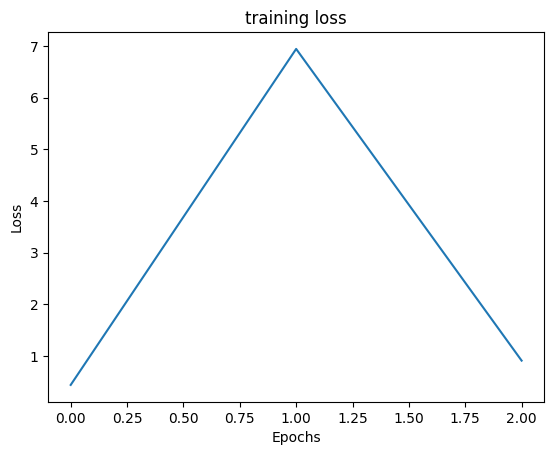

In [10]:
# build and compile the model
input_shape = (X.shape[1], X.shape[2])
inputs= tf.keras.Input(shape=input_shape)
x = tf.keras.layers.Dense(64)(inputs) # reduced embed_dim for faster runs
transformer_block = TransformerBlock(embed_dim=64, num_heads=4, ff_dim=128)
# reduce model complexity
x = transformer_block(x,training = True)
flatten = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(1)(flatten)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='mean_squared_error')

# early stopping to stop training when no improvment is seen
early_stopping = EarlyStopping(monitor='loss', patience=2,restore_best_weights=True)

#train the model with reduced epochs and steps
history = model.fit(X, Y, epochs=5, batch_size=32, callbacks=[early_stopping], steps_per_epoch=10)

#plot training
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("training loss")
plt.show()


In [ ]:
# exercise 2 : implement a learning rate scheduler to adjust the learning rate during training
# Instruction : Define a learning rate scheduler that reduces the learning rate by half every 10 epochs
#               train the model with the learning rate scheduler and compare the training loss


In [15]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

def scheduler(epoch, lr):
    if epoch > 0 and epoch % 10 == 0:
        return lr * 0.5
    return lr

early_stopping = EarlyStopping(monitor='loss', patience=2, restore_best_weights=True)
lr_scheduler = LearningRateScheduler(scheduler)

history_with_scheduler= model.fit(
    X, Y,
    epochs=30,
    batch_size=32,
    steps_per_epoch=10,
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.1459 - learning_rate: 0.0010
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1150 - learning_rate: 0.0010
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3214 - learning_rate: 0.0010
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1318 - learning_rate: 0.0010
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5570 - learning_rate: 0.0010
Epoch 6/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8972 - learning_rate: 0.0010


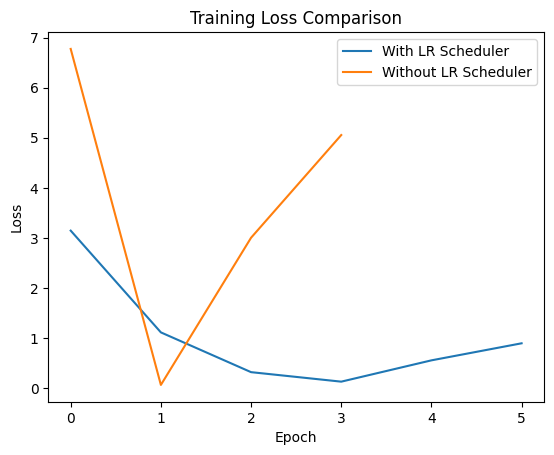

In [16]:
plt.plot(history_with_scheduler.history['loss'], label='With LR Scheduler')
plt.plot(history.history['loss'], label='Without LR Scheduler')
plt.legend()
plt.title("Training Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

**why the loss gradually decrease with a learning rate scheduler**

1. Early training : High learning rate



*   At the beginning, the learning rate is high, which allows the model to make quick progress towards a good local minimun and optimize more quickly.

2. Later training : Low learning rate


*   As training continues, the learning rate is reduced, allowing the model to adjust its weights more prescisely. This result in more stable learning and the model avoids making large updates that could lead to instability,causing the loss to steadily decrease.  


**Why the loss fluctuates rapidly without a learning rate scheduler**

1. Large updates in early training




*   In the beginning, a high learning rate may cause the model to make rapid progress but could also lead to it jumping over optimal points or not converging properly.
*   As training continues, if the learning rate remains high, the model may become unstable and fail to converge properly. This could cause the model to overshoot the optimal value, resulting in fluctuations or divergence in the loss


**Summary**
*   Model with learning rate scheduler:
    the learning rate gradually decrease,
    allowing the model to optimize more stably, and the loss consistently decrease.

*   Model without a scheduler:
    with a fixed learning rate, the model might converge(모이다) quickly at first,but it can become unstable later in training, causing the loss to fluctuate(변동하다) or increase sharply.






